thoughts to work on (Sept 27, 2022)
- need to do FBEYE vetting of every Month of data
- need to do new GP model for background subtraction, improve Equiv Dur calc
- need to measure very general starspot properties
- need to compute best FFD fits, w/ MCMC
- need to compute some kind(s) of flare activity variation metrics
- structure-function like metric?


In [61]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightkurve as lk
from astropy.table import Table
from scipy.stats import binned_statistic
# from scipy.signal import savgol_filter
# from scipy.interpolate import CubicSpline

from stuff import *
import exoplanet as xo

from glob import glob

import sys
sys.path.append('/Users/james/Dropbox/research_projects/FFD/')
from FFD import FFD

In [62]:
import matplotlib
matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

In [38]:
#  Flare files from notebook: 02 - Flare Finding
files = glob('../data/KIC_8507979*') 

print(len(files))

lfl_lbol = np.zeros(len(files))
lfl_lbol_err = np.zeros(len(files))
time = np.zeros(len(files))
for k in range(len(files)):
    df = pd.read_csv(files[k])
    totdur = 1 / (10**df['ffd_y'].values[0])
    lfl_lbol[k] = np.sum(df['ED'][df['ED'] > 0]) / (totdur * 24*60*60)
    lfl_lbol_err[k] = np.sqrt(np.sum((df['EDerr']**2)[df['ED'] > 0])) / (totdur * 24*60*60)
    
    time[k] = np.nanmedian(df['tstart'])
    if k==0:
        df_big = df
    else:            
        df_big = pd.concat([df_big, df], ignore_index=True)

df_big.shape

23


(3954, 8)

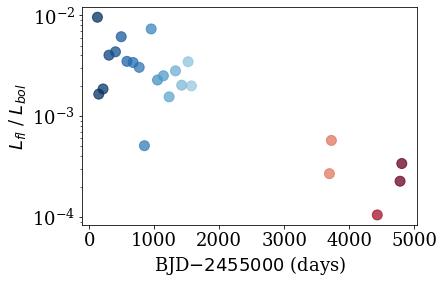

In [43]:
plt.scatter(time-2455000, (lfl_lbol), c=time, cmap=plt.cm.RdBu_r, s=100, alpha=0.75)
# plt.errorbar(time-2455000, (lfl_lbol), yerr=lfl_lbol_err, linestyle='none')
plt.xlabel('BJD$- 2455000$ (days)')
plt.ylabel('$L_{fl}$ / $L_{bol}$')
plt.yscale('log')
plt.savefig('../figures/KIC_8507979.pdf', dpi=150, bbox_inches='tight', pad_inches=0.25, facecolor='w')

Text(0, 0.5, 'dF')

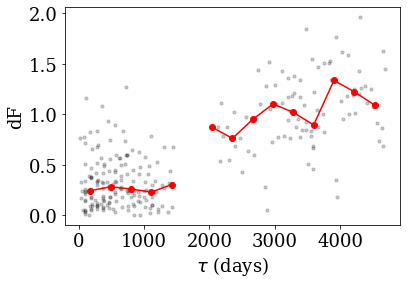

In [81]:
dt_big = np.array([])
dL_big = np.array([])
for k in range(len(lfl_lbol)):
    dt = np.abs(time - time[k])
    dL = np.abs(np.log10(lfl_lbol) - np.log10(lfl_lbol[k]))
    dt_big = np.append(dt_big, dt)
    dL_big = np.append(dL_big, dL)

bigOK = (dt_big > 0) & (dL_big > 0)
dt_big = dt_big[bigOK]
dL_big = dL_big[bigOK]

ss, be, bn = binned_statistic(dt_big, dL_big, 'median', bins=15, )

plt.scatter(dt_big, dL_big, c='k', alpha=0.1,s=10)
plt.plot((be[1:]+be[:-1])/2, ss, marker='o', c='r')


plt.xlabel(r'$\tau$ (days)')
plt.ylabel(r'dF')

# plt.yscale('log')
# plt.xscale('log')


In [4]:
lk.search_lightcurve('8507979', mission='TESS')

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 14,2019,SPOC,120,272272592,0.0
1,TESS Sector 14,2019,TESS-SPOC,1800,272272592,0.0
2,TESS Sector 14,2019,QLP,1800,272272592,0.0
3,TESS Sector 15,2019,SPOC,120,272272592,0.0
4,TESS Sector 15,2019,TESS-SPOC,1800,272272592,0.0
5,TESS Sector 15,2019,QLP,1800,272272592,0.0
6,TESS Sector 41,2021,SPOC,120,272272592,0.0
7,TESS Sector 41,2021,TESS-SPOC,600,272272592,0.0
8,TESS Sector 41,2021,QLP,600,272272592,0.0


(-0.5, 4.0)

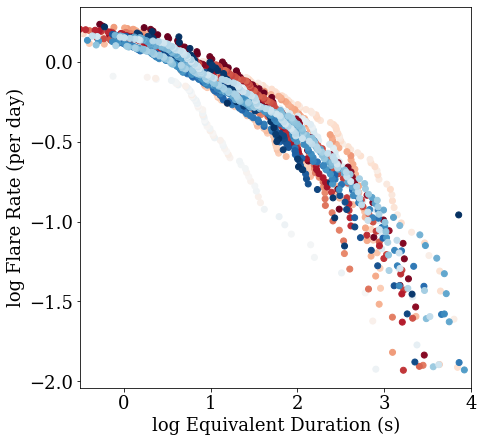

In [6]:
kk = df_big['tstart'] <  2457000
tt = df_big['tstart'] >  2457000
plt.figure(figsize=(7,7)) 
# plt.errorbar(df_big['ffd_x'], df_big['ffd_y'], xerr=df_big['ffd_xerr'], yerr=df_big['ffd_yerr'], 
#              color='k', alpha=0.2, linestyle='none')

# plt.scatter(df_big['ffd_x'], df_big['ffd_y'], c=df_big['tstart'], cmap=plt.cm.RdBu_r)

plt.scatter(df_big['ffd_x'][kk], df_big['ffd_y'][kk], c=df_big['tstart'][kk], cmap=plt.cm.RdBu_r)
# plt.scatter(df_big['ffd_x'][tt], df_big['ffd_y'][tt], c=df_big['tstart'][tt], cmap=plt.cm.Spectral, 
#             marker='*', s=100)

# plt.plot([0,3], [1,-2], c='k')

plt.xlabel('log Equivalent Duration (s)')
plt.ylabel('log Flare Rate (per day)')
plt.xlim(-0.5,4)


In [8]:
lc_k = lk.search_lightcurve('8507979', mission='TESS', exptime=120)
len(lc_k)

5

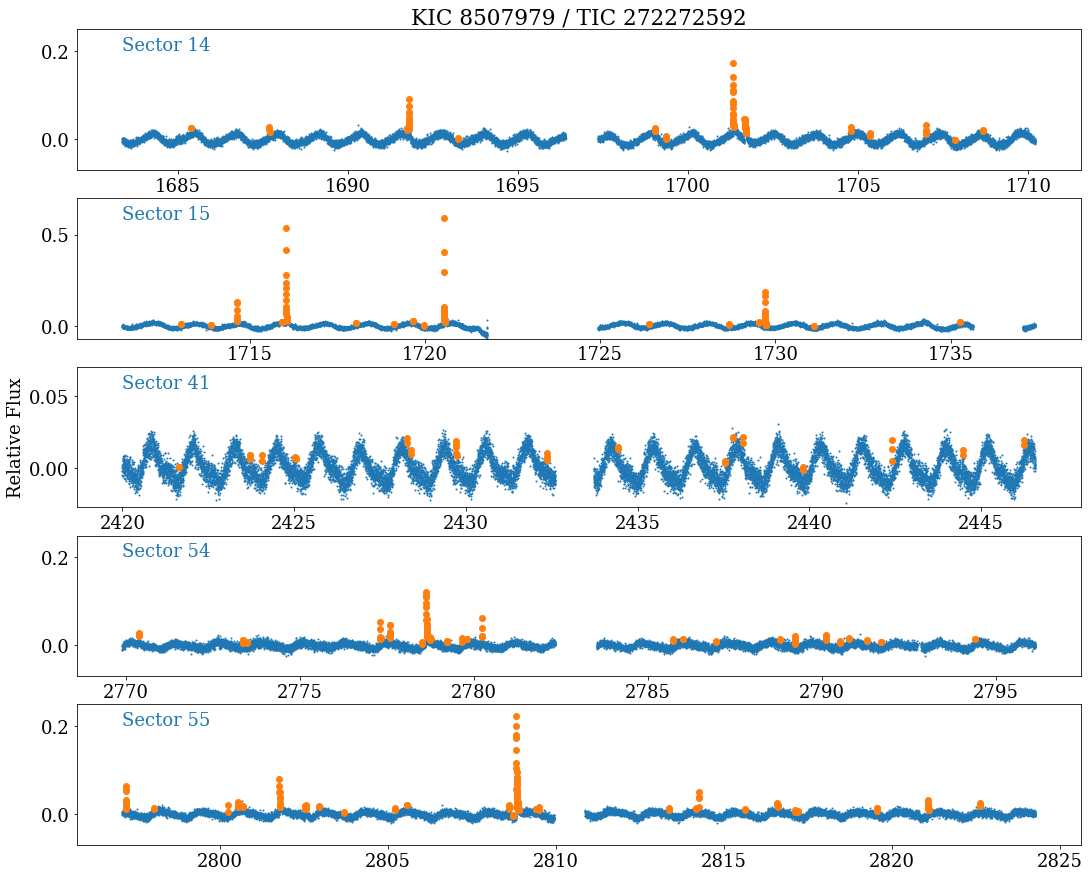

In [16]:
ylim = [[-.07,.25],[-.07,.7],[-.027,.07], [-.07,.25],[-.07,.25]]

fig, axs = plt.subplots(len(lc_k), 1, figsize=(18,int(3*len(lc_k))))

lfl_lbol_T = np.zeros(len(lc_k))
time_T = np.zeros(len(lc_k))

for j in range(len(lc_k)):
    lc = lc_k[j].download()


    # make harsh quality cuts, and chop out a known bad window of time (might add more later)
    AOK = (lc['quality'].data == 0)  & np.isfinite(lc['pdcsap_flux'].value) & ((lc['time'].value < 1347) | (lc['time'].value > 1350))
    med = np.nanmedian(lc['pdcsap_flux'].value[AOK])
    xtr = 5

    # ACF w/ Exoplanet package
    acf = xo.autocorr_estimator(lc['time'].value[AOK], lc['pdcsap_flux'].value[AOK] / med,
                                yerr=lc['pdcsap_flux_err'].value[AOK] / med,
                                min_period=0.07, max_period=27, max_peaks=2)
    if len(acf['peaks']) > 0:
        ACF_1dt = acf['peaks'][0]['period']
        ACF_1pk = acf['autocorr'][1][np.where((acf['autocorr'][0] == acf['peaks'][0]['period']))[0]][0]

        scl = np.abs(np.nanmedian(np.diff(lc['time'].value)))
        s_window = int(ACF_1dt / scl / xtr)
    else:
        s_window = 128
#     print(ACF_1dt)

    # window must be odd for some smooth approaches
    if (s_window % 2) == 0:
        s_window -= 1

    yerr = lc['pdcsap_flux_err'].value[AOK] / med
    x = lc['time'].value[AOK]
    y = (lc['pdcsap_flux'].value[AOK] - med)/med

#     ymodel = phase_med(x,(y+1)*med,ACF_1dt, k=s_window)
    
    # find flares
    FM, xhat, yhat = iflare(x, y, yerr, s_window, npass=8, 
                            N1=1, N2=1, N3=2)

#     print(sum(FM))
    if sum(FM) > 0:
        # split the flares into start/stops
        istart, istop = flaresplit(FM, dlim=5)

        # measure equiv durations (energies)
        ED = np.zeros(len(istart), dtype=float)
        EDerr = np.zeros(len(istart), dtype=float)
        for l in range(len(istart)):
            ED[l], EDerr[l] = EquivDur(x,y,yerr, xhat,yhat, istart[l],istop[l])

        # compute FFD properties for this star
        TOTEXP = np.nanmedian(np.diff(lc.time.value)) * len(x)
        ffd_x, ffd_y, ffd_xerr, ffd_yerr = FFD(ED, TOTEXP=TOTEXP, 
                                               Lum=0., fluxerr=np.nanmedian(yerr), 
                                               dur = x[istop]-x[istart])
        lfl_lbol_T[j] = np.sum(ED[ED > 0]) / (TOTEXP * 24*60*60)
        time_T[j] = np.nanmedian(lc.time.value)

#         # sort flares like FFD does
#         ss = np.argsort(np.array(ED))[::-1]
        # save flare properties for this light curve
#         df = pd.DataFrame(data={'tstart':x[istart][ss]+ 2457000, 'tstop':x[istop][ss] + 2457000, 
#                                 'ED':ED[ss], 'EDerr':EDerr[ss],
#                                 'ffd_x':ffd_x, 'ffd_y':ffd_y, 
#                                 'ffd_xerr':ffd_xerr, 'ffd_yerr':ffd_yerr})


#         filename = 'KIC_'+str(FS['KIC'].values[k]) + '_TESS_' + str(lc.SECTOR)
#         df.to_csv('../data/'+filename+'.csv', index=False, index_label=False)

#         plt.figure(figsize=(6,6))
#         plt.errorbar(ffd_x, ffd_y, xerr=ffd_xerr, yerr=ffd_yerr, marker='o', linestyle='none', 
#                      label='N='+str(len(ffd_x)))
#         plt.legend()
#         plt.title(filename, fontsize=12)
#         plt.xlabel('log Equivalent Duration (s)')
#         plt.ylabel('log Flare Rate (per day)')
#         plt.savefig('../figures/'+filename+'_ffd.png', dpi=150, bbox_inches='tight', pad_inches=0.25, facecolor='w')
#         plt.close()

#         plt.figure(figsize=(13,3))
        axs[j].scatter(x,y,s=1)
        axs[j].scatter(x[FM>0], y[FM>0], c='C1')

        axs[j].set_ylim(ylim[j][0], ylim[j][1])
        axs[j].text(x.min(), ylim[j][1] - ((ylim[j][1] - ylim[j][0])*0.15), 
                    'Sector '+str(lc.SECTOR), color='C0')
axs[2].set_ylabel('Relative Flux')
axs[2].set_xlabel('Time (BJD-2457000 days)')
axs[0].set_title('KIC 8507979 / '+lc.LABEL)
plt.savefig('../figures/AstroFest2022_stack_lc.png', dpi=150, bbox_inches='tight', pad_inches=0.25, facecolor='w')

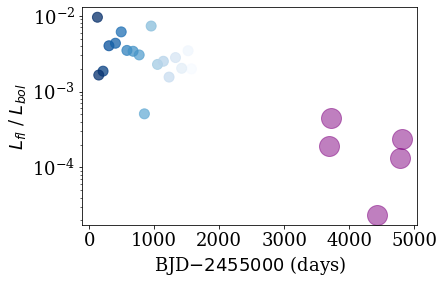

In [37]:

plt.scatter(time[time-2455000 < 2000]-2455000, (lfl_lbol[time-2455000 < 2000]), 
            c=time[time-2455000 < 2000], cmap=plt.cm.Blues_r, s=100, alpha=0.75)
plt.scatter(time_T+2457000-2455000, (lfl_lbol_T), c='purple', s=400, alpha=0.5)
# plt.errorbar(time-2455000, (lfl_lbol), yerr=lfl_lbol_err, linestyle='none')
plt.xlabel('BJD$- 2455000$ (days)')
plt.ylabel('$L_{fl}$ / $L_{bol}$')
plt.yscale('log')
plt.savefig('KIC_8507979_AstroFest2022.png', dpi=150, bbox_inches='tight', pad_inches=0.25, facecolor='w')

469.0
380.0
454.0


(-1.0, 2.5)

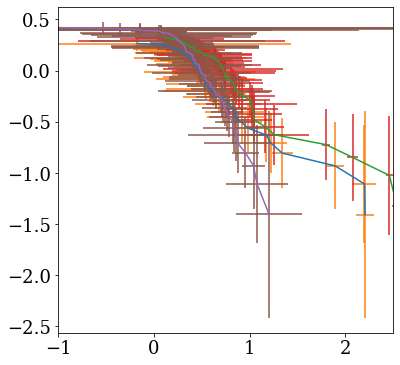

In [82]:
plt.figure(figsize=(6,6))
for j in range(len(lc_k)):
    lc = lc_k[j].download()

    # make harsh quality cuts, and chop out a known bad window of time (might add more later)
    AOK = (lc['quality'].data == 0)  & np.isfinite(lc['pdcsap_flux'].value) & ((lc['time'].value < 1347) | (lc['time'].value > 1350))
    med = np.nanmedian(lc['pdcsap_flux'].value[AOK])
    xtr = 5

    # ACF w/ Exoplanet package
    acf = xo.autocorr_estimator(lc['time'].value[AOK], lc['pdcsap_flux'].value[AOK] / med,
                                yerr=lc['pdcsap_flux_err'].value[AOK] / med,
                                min_period=0.07, max_period=27, max_peaks=2)
    if len(acf['peaks']) > 0:
        ACF_1dt = acf['peaks'][0]['period']
        ACF_1pk = acf['autocorr'][1][np.where((acf['autocorr'][0] == acf['peaks'][0]['period']))[0]][0]

        scl = np.abs(np.nanmedian(np.diff(lc['time'].value)))
        s_window = int(ACF_1dt / scl / xtr)
    else:
        s_window = 128
#     print(ACF_1dt)

    # window must be odd for some smooth approaches
    if (s_window % 2) == 0:
        s_window -= 1

    yerr = lc['pdcsap_flux_err'].value[AOK] / med
    x = lc['time'].value[AOK]
    y = (lc['pdcsap_flux'].value[AOK] - med)/med

#     ymodel = phase_med(x,(y+1)*med,ACF_1dt, k=s_window)
    
    # find flares
    FM, xhat, yhat = iflare(x, y, yerr, s_window, npass=8, 
                            N1=1, N2=1, N3=1)

    print(sum(FM))
    if sum(FM) > 0:
        # split the flares into start/stops
        istart, istop = flaresplit(FM, dlim=5)

        # measure equiv durations (energies)
        ED = np.zeros(len(istart), dtype=float)
        EDerr = np.zeros(len(istart), dtype=float)
        for l in range(len(istart)):
            ED[l], EDerr[l] = EquivDur(x,y,yerr, xhat,yhat, istart[l],istop[l])

        # compute FFD properties for this star
        TOTEXP = np.nanmedian(np.diff(lc.time.value)) * len(x)
        ffd_x, ffd_y, ffd_xerr, ffd_yerr = FFD(ED, TOTEXP=TOTEXP, 
                                               Lum=0., fluxerr=np.nanmedian(yerr), 
                                               dur = x[istop]-x[istart])
        plt.plot(ffd_x, ffd_y)
#         # sort flares like FFD does
#         ss = np.argsort(np.array(ED))[::-1]
        # save flare properties for this light curve
#         df = pd.DataFrame(data={'tstart':x[istart][ss]+ 2457000, 'tstop':x[istop][ss] + 2457000, 
#                                 'ED':ED[ss], 'EDerr':EDerr[ss],
#                                 'ffd_x':ffd_x, 'ffd_y':ffd_y, 
#                                 'ffd_xerr':ffd_xerr, 'ffd_yerr':ffd_yerr})


#         filename = 'KIC_'+str(FS['KIC'].values[k]) + '_TESS_' + str(lc.SECTOR)
#         df.to_csv('../data/'+filename+'.csv', index=False, index_label=False)

        plt.errorbar(ffd_x, ffd_y, xerr=ffd_xerr, yerr=ffd_yerr, linestyle='none', 
                     label='N='+str(len(ffd_x)))

#         plt.legend()
#         plt.title(filename, fontsize=12)
#         plt.xlabel('log Equivalent Duration (s)')
#         plt.ylabel('log Flare Rate (per day)')
#         plt.savefig('../figures/'+filename+'_ffd.png', dpi=150, bbox_inches='tight', pad_inches=0.25, facecolor='w')
#         plt.close()
plt.xlim(-1,2.5)
# plt.savefig('../figures/ADAP_stack_lc.png', dpi=150, bbox_inches='tight', pad_inches=0.25, facecolor='w')

In [26]:
# prep light curve (and output?) files for FBEYE validation
# Kepler 30-min DATA

lc_k = lk.search_lightcurve('8507979', mission='Kepler', exptime=1800)

for j in range(len(lc_k)):
    lc = lc_k[j].download()

    # make harsh quality cuts, and chop out a known bad window of time (might add more later)
    AOK = (lc['quality'].data == 0) & np.isfinite(lc['pdcsap_flux'].value)
    
    # ACF w/ Exoplanet package
    acf = xo.autocorr_estimator(lc['time'].value[AOK], lc['pdcsap_flux'].value[AOK] ,
                                yerr=lc['pdcsap_flux_err'].value[AOK] ,
                                min_period=0.07, max_period=27, max_peaks=2)
    if len(acf['peaks']) > 0:
        ACF_1dt = acf['peaks'][0]['period']
        ACF_1pk = acf['autocorr'][1][np.where((acf['autocorr'][0] == acf['peaks'][0]['period']))[0]][0]

    per = ACF_1dt
    
    yerr = lc['pdcsap_flux_err'].value[AOK] 
    x = lc['time'].value[AOK]
    y = lc['pdcsap_flux'].value[AOK] 
    
    model1 = phase_med(x,y,per) 
    smo = y - (model1 * np.nanmedian(y))
#     df_out = pd.DataFrame(data={'time':x, 'flux':y, 'err':yerr})
#     filename = 'KIC_8507979_KepL_' + str(lc.QUARTER) + '_lc'

    df_out = pd.DataFrame(data={'time':x, 'flux':smo, 'err':yerr})
    filename = 'KIC_8507979_KepL_' + str(lc.QUARTER) + '_lc_smo'
    
    df_out.to_csv(filename+'.csv', index=False, index_label=False, header=False)
